In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from optimizers.customAdam5 import customAdam5
import pickle

In [2]:
transforms = transforms.Compose([transforms.ToTensor()])
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# MNIST dataset
train_dataset = datasets.CIFAR10(root='../datasets/',
                               train=True,
                               transform=transforms,
                               download=True)

test_dataset = datasets.CIFAR10(root='../datasets/',
                                train=False,
                                transform=transforms)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False)


Files already downloaded and verified


In [4]:
# defining the model
# We show the
# effectiveness of Adam in deep CNNs. Our CNN architecture has three alternating stages of 5x5
# convolution filters and 3x3 max pooling with stride of 2 that are followed by a fully connected layer
# of 1000 rectified linear hidden units (ReLU’s).
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)  # 3 input channels, 64 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2) # 64 input channels, 64 output channels, 5x5 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2) # 64 input channels, 128 output channels, 5x5 kernel

        self.fc1 = nn.Linear(128 * 3 * 3, 1000)  # 128 * 4 * 4 input features, 1000 output features
        self.fc2 = nn.Linear(1000, 10)  # 1000 input features, 10 output classes
        
    def forward(self, x):
        # Convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        # Flatten the feature maps
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))

        
        # Output layer with softmax activation
        x = self.fc2(x)
        # x = F.log_softmax(x, dim=1)

        return x


In [5]:
# training the model
criterion = nn.CrossEntropyLoss()
epochs = 100

In [6]:
# A class containing the functions for
class Trainer():
    def __init__(self, model, optimizer, lr=0.001, epochs=5):
        self.model = model

        self.lr = lr
        self.optimizer = optimizer(self.model.parameters(), lr=lr)

        self.epochs = epochs

        # defining local variables for the class
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []


    def train(self):
        # train loop
        self.model.train()

        for epoch in range(self.epochs):
            running_loss = 0

            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.to(device), target.to(device)
                self.optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                self.optimizer.step()
                
                running_loss += loss.item()
                accuracy = 100*torch.sum(torch.argmax(output, dim=1) == target).item()/len(target)

                # break

            self.train_loss.append(running_loss/len(train_loader))
            self.train_acc.append(accuracy)


            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = self.model(data)
                    val_loss += criterion(output, target).item()

                    val_acc = 100*torch.sum(torch.argmax(output, dim=1) == target).item()/len(target)

            self.val_loss.append(val_loss/len(test_loader))
            self.val_acc.append(val_acc)

            if (epoch%10==9):
                print(f"Epoch: {epoch+1}/{epochs} ::     Train Loss: {running_loss/len(train_loader)}...     Val Loss: {val_loss/len(test_loader)}")                    

        return
        

    def plot_graph(self):
        epoch_x = [i for i in range(1, self.epochs+1)]
        
        # plot loss and accuracy curves for train and validation in two separate graphs
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        axs[0].plot(epoch_x, self.train_loss, label='Train Loss')
        axs[0].plot(epoch_x, self.val_loss, label='Val Loss')
        axs[0].set_title('Loss')
        axs[0].legend()

        axs[1].plot(epoch_x, self.train_acc, label='Train Accuracy')
        axs[1].plot(epoch_x, self.val_acc, label='Val Accuracy')
        axs[1].set_title('Accuracy')
        axs[1].legend()

        return         

In [7]:
'''
https://pytorch.org/docs/stable/generated/torch.addcdiv.html#torch.addcdiv

For addcdiv_ used at last

'''
class customAdam(torch.optim.Optimizer):


    def __init__(self,params,lr = 1e-3,betas = (0.99,0.999),eps = 1e-3):
        defaults = dict(lr = lr, betas = betas, eps = eps)
        super(customAdam,self).__init__(params,defaults)

    def __setstate__(self, state) -> None:
        return super(customAdam).__setstate__(state)
  
    def step(self,closure = None):
        loss = None
        if closure is not None:
            loss = closure()
        for group in self.param_groups:
            # print(self.param_groups)
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                # print(grad)
                state = self.state[p]
                # print(state)
                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    beta1, beta2 = group['betas']
                    state['step'] += 1

                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1 - beta1
                    bias_correction2 = 1 - beta2

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

                else:
                    beta1, beta2 = group['betas']
                    state['step'] += 1
                    state['exp_avg'] = beta1 * state['exp_avg'] + (1 - beta1) * grad
                    state['exp_avg_sq'] = beta2 * state['exp_avg_sq'] + (1 - beta2) * grad**2

                    bias_correction1 = 1
                    bias_correction2 = 1

                    p.data.addcdiv_(-group['lr'] / bias_correction1,state['exp_avg'],(state['exp_avg_sq'] / bias_correction2).sqrt() + group['eps'])

        return loss


In [8]:
model = CNN().to(device)
trainer = Trainer(model, customAdam5, epochs=epochs)

In [9]:
trainer.train()

Epoch: 10/100 ::     Train Loss: 2.1167426060657113...     Val Loss: 2.1196508169174195
Epoch: 20/100 ::     Train Loss: 2.1338969493398863...     Val Loss: 2.1331528663635253
Epoch: 30/100 ::     Train Loss: 2.104246056809717...     Val Loss: 2.1104771375656126
Epoch: 40/100 ::     Train Loss: 2.221820067386238...     Val Loss: 2.2169408082962034
Epoch: 50/100 ::     Train Loss: 2.182534855239245...     Val Loss: 46.32957503795624
Epoch: 60/100 ::     Train Loss: 2.1645400718766816...     Val Loss: 470.717867565155
Epoch: 70/100 ::     Train Loss: 3.4884287435181287...     Val Loss: 2.1560667991638183
Epoch: 80/100 ::     Train Loss: 2.138238760889793...     Val Loss: 2.136851501464844
Epoch: 90/100 ::     Train Loss: 2.105085144237596...     Val Loss: 2.165427589416504
Epoch: 100/100 ::     Train Loss: 2.1023837254971873...     Val Loss: 2.315522885322571


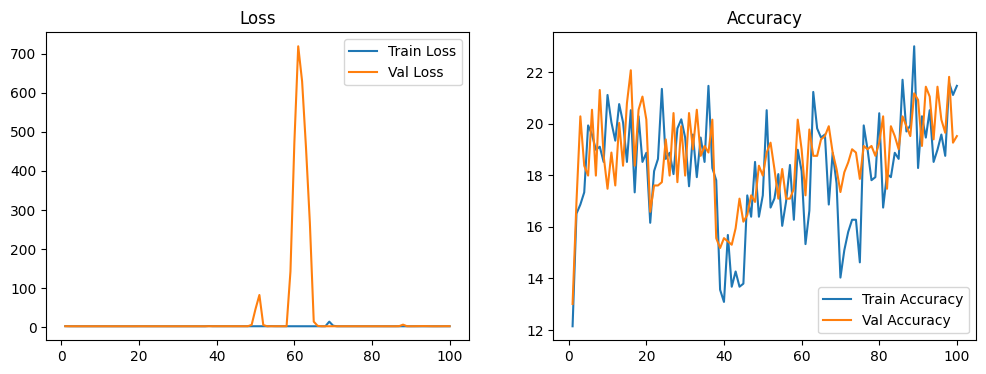

In [10]:
trainer.plot_graph()